### In this notebook, we apply `popsed` to GAMA photometry catalog.

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor
from torch.distributions import MultivariateNormal
from geomloss import SamplesLoss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator, StandardScaler
import popsed
from popsed import prior

Input parameters : logmstar, kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift


**Input parameters : logmstar, InvSigmoid(kappa1_sfh), InvSigmoid(kappa2_sfh), InvSigmoid(kappa3_sfh), log10(fburst), log10(tburst), logzsol, log10(dust1), log10(dust2), dust_index, log10(redshift)**

We still need penalty on logzsol and dust_index

(10 params)

beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh = Transform(kappa1_sfh, kappa2_sfh, kappa3_sfh)

In [45]:
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
name = 'NMF'
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}.emu_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=['.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'logzsol',
                 'dust1', 'dust2', 
                 'dust_index', 'redshift', 'logm'],
    device='cuda', use_speclite=True)#, use_speclite=True)

gama_filters = ['sdss2010-{0}'.format(b) for b in 'ugriz']# + ['VIKING_{0}'.format(b) for b in ['Y']]
speculator._calc_transmission(gama_filters)

# gama_filters = ['sdss_{0}0'.format(b) for b in 'ugriz']# + ['VIKING_{0}'.format(b) for b in ['Y']]
# speculator._calc_transmission(gama_filters, filter_dir='./filters/gama/')

noise = 'snr' #'gama'
noise_model_dir = './noise_model/gama_noise_model_mag_dr3_apmatch.npy'

In [46]:
test_par = torch.Tensor([[.1, 0.1, 0.1, 0.0, 4, -1.2, 1.2, 1.2, 0, 0.02, 8.0],
                         [0.5, 0.5, 0.5, 0.5, 4, -1.2, 1.2, 1.2, 0, 0.3, 10.0]]).to('cuda')
speculator._predict_mag_with_mass_redshift(test_par)

tensor([[21.9987, 20.7522, 20.1936, 19.8475, 19.5986],
        [24.7529, 23.5505, 22.3435, 21.8516, 21.4972]], device='cuda:0',
       grad_fn=<MulBackward0>)

In [47]:
### VIKING filters: http://casu.ast.cam.ac.uk/surveys-projects/vista/technical/filter-set

#### Load GAMA photometry catalog

In [48]:
from astropy.table import Table
from popsed.utils import flux2mag, sigma_flux2mag

In [60]:
mags_gama = np.load('./reference_catalog/GAMA/gama_clean_mag_dr3_apmatch.npy')[:, :5]
print(len(mags_gama))

# flag = ((mags_gama[:, 0] - mags_gama[:, 1]) > 0)
# flag &= ((mags_gama[:, 1] - mags_gama[:, 2]) > 0)
# flag &= ((mags_gama[:, 1] - mags_gama[:, 4]) > 0)
# flag &= ((mags_gama[:, 2] - mags_gama[:, 3]) > 0)
# flag &= ((mags_gama[:, 2] - mags_gama[:, 4]) > 0)
# mags_gama = mags_gama[flag][:, :]
len(mags_gama)

102655


102655

In [61]:
X_data = mags_gama[:, :]
# X_data = X_data[np.random.choice(np.arange(len(X_data)), 80000, replace=False)]
print('Total number of samples:', len(X_data))

Total number of samples: 102655


In [28]:
del mags_gama
import gc
gc.collect()
torch.cuda.empty_cache()

In [62]:
# Determine the intrinsic sampling loss
X_datas = []
for i in range(2):
    ind = np.random.randint(0, len(X_data), 10000)
    X_datas.append(torch.Tensor(X_data[ind]).to('cuda'))
    
L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 0.1, 'scaling': 0.5})
print("Intrinsic sampling loss:", L(X_datas[0], X_datas[1]).item())
intr_loss = L(X_datas[0], X_datas[1]).item()
# Intrinsic sampling loss: 0.01805417239665985

Intrinsic sampling loss: 0.0342378132045269


In [29]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

In [31]:
_prior_NDE = speculator.bounds.copy()
# _prior_NDE[:4] = np.array([[0.1, 0.9], [0.1, 0.9], [0.1, 0.9], [0.1, 0.9]]) # include fburst
# _prior_NDE[4] = np.array([1, 10])

# _prior_NDE[5] = np.array([-2.3, 0.2]) # logzsol
# _prior_NDE[6] = np.array([0.1, 2.9])
# _prior_NDE[7] = np.array([0.1, 1.6])
_prior_NDE[-2] = np.array([0., 1])
# _prior_NDE[-1] = np.array([7.5, 12.5])
_prior_NDE[-1] = np.array([6, 13.])

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshif, logmstar, 

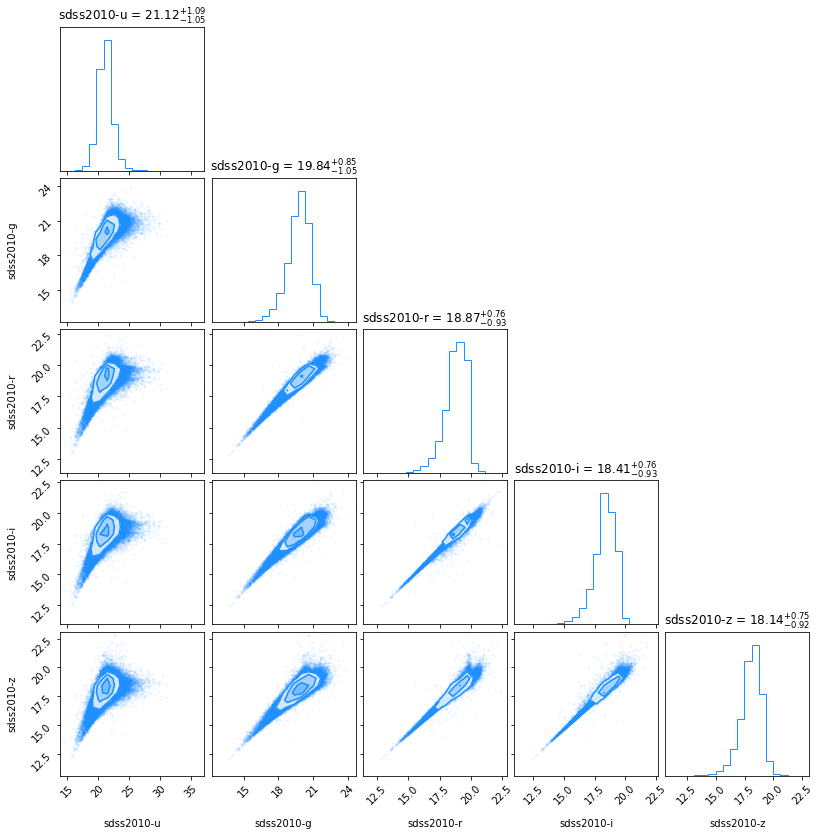

In [32]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Noise-less photometry')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'Noisy photometry')

labels = gama_filters # [f'sdss\_{f}0' for f in 'ugriz']

figure = corner.corner(X_data,#.cpu().detach().numpy()[:, :], 
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

# ax = nf_plot.get_axes()[4]
# ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar

In [33]:
X_train, X_vali = train_test_split(X_data, test_size=0.15)
Y_train = torch.ones(len(X_train), 11)

### now we provide the redshift distribution to it

In [34]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss

In [49]:
seed = 4
np.random.seed(seed)

_bounds = speculator.bounds.copy()
_bounds = np.zeros_like(_bounds)
_bounds = np.vstack([-np.abs(np.random.normal(size=len(_bounds)) / 30), 
                   np.abs(np.random.normal(size=len(_bounds)) / 30)]).T

_stds = np.ones(len(_bounds))

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf',
                                              name='NMF',
                                              num_transforms=15,  # 10
                                              num_bins=50,  # how smashed it is. 10
                                              hidden_features=100,  # 120,
                                              seed=seed,
                                              output_dir=None,
                                              initial_pos={'bounds': _bounds,
                                                           'std': _stds,
                                                           },
                                              normalize=False,
                                              regularize=True, 
                                              NDE_prior=_prior_NDE,#np.vstack([_prior_NDE[:-2], _prior_NDE[-1:]])
                                             )

In [50]:
NDE_theta.build(
    Y_train,#[:, :-1],
    X_train,
    filterset=gama_filters,
    z_score=False,
    optimizer='adam')
NDE_theta.load_validation_data(X_vali)
NDE_theta.bounds = speculator.bounds
NDE_theta.params_name = speculator.params_name

print('Total number of params in the model:', 
      sum(p.numel() for p in NDE_theta.net.parameters() if p.requires_grad))

NDE_theta.external_redshift_data = None

[ 0.00278063  0.00020838  0.00986578  0.02097025  0.00394868 -0.03703416
  0.04983031 -0.01967798 -0.00788417 -0.00737224 -0.00313551]
Total number of params in the model: 1866747


In [37]:
# del X_data
gc.collect()
torch.cuda.empty_cache()

In [52]:
max_epochs = 6
# blurs = [0.002, 0.002]# * 4
# blurs = [0.1, 0.1, 0.05, 0.05, 0.05, 0.05]
# blurs = [0.2, 0.1, 0.1, 0.05, 0.05]
# blurs = [0.3, 0.2, 0.2, 0.2, 0.2, 0.1]
blurs = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3]


scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=8e-4, #5e-4, 1e-3
                                                steps_per_epoch=60,
                                                epochs=max_epochs)
for i, epoch in enumerate(range(max_epochs)):
    print('    Epoch {0}'.format(epoch))
    print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    print('    blur:', blurs[i])
    
    NDE_theta.train(n_epochs=60,
                    speculator=speculator,
                    add_penalty=False,
                    noise=noise, SNR=15, #noise_model_dir=noise_model_dir,
                    sinkhorn_kwargs={
                        'p': 1, 'blur': blurs[i], 'scaling': 0.5},
                    scheduler=scheduler, detect_anomaly=False,
                    )

    Epoch 0
    lr: 3.200000000000002e-05
    blur: 0.3


Loss = 0.629 (train), 0.625 (vali), 2.555 (bad ratio): 100%|█████| 60/60 [02:30<00:00,  2.51s/epochs]


    Epoch 1
    lr: 0.0004888402093625246
    blur: 0.3


Loss = 0.064 (train), 0.063 (vali), 1.453 (bad ratio):  75%|███▊ | 45/60 [01:58<00:39,  2.63s/epochs]


KeyboardInterrupt: 

In [23]:
max_epochs = 6
# blurs = [0.002, 0.002]# * 4
blurs = [0.1, 0.1, 0.05, 0.05, 0.05, 0.05]
# blurs = [0.2, 0.1, 0.1, 0.05, 0.05]
# blurs = [0.3, 0.2, 0.1, 0.1, 0.1, 0.1]
# blurs = [0.3, 0.2, 0.1, 0.1, 0.05, 0.05, 0.01]


scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=1e-4, #5e-4, 1e-3
                                                steps_per_epoch=60,
                                                epochs=max_epochs)
for i, epoch in enumerate(range(max_epochs)):
    print('    Epoch {0}'.format(epoch))
    print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    print('    blur:', blurs[i])
    
    NDE_theta.train(n_epochs=60,
                    speculator=speculator,
                    add_penalty=False,
                    noise=noise, noise_model_dir=noise_model_dir,
                    sinkhorn_kwargs={
                        'p': 1, 'blur': blurs[i], 'scaling': 0.5},
                    scheduler=scheduler, detect_anomaly=False,
                    )

    Epoch 0
    lr: 4.000000000000002e-06
    blur: 0.1


Loss = 0.061 (train), 0.061 (vali), 1.108 (bad ratio): 100%|█████| 60/60 [01:27<00:00,  1.46s/epochs]


    Epoch 1
    lr: 6.110502617031558e-05
    blur: 0.1


Loss = 0.055 (train), 0.057 (vali), 1.205 (bad ratio): 100%|█████| 60/60 [01:29<00:00,  1.49s/epochs]


    Epoch 2
    lr: 9.93448015636403e-05
    blur: 0.05


Loss = 0.094 (train), 0.100 (vali), 1.315 (bad ratio): 100%|█████| 60/60 [01:30<00:00,  1.51s/epochs]


    Epoch 3
    lr: 8.068481700064342e-05
    blur: 0.05


Loss = 0.095 (train), 0.098 (vali), 1.305 (bad ratio): 100%|█████| 60/60 [01:29<00:00,  1.50s/epochs]


    Epoch 4
    lr: 4.564243029376564e-05
    blur: 0.05


Loss = 0.092 (train), 0.097 (vali), 1.275 (bad ratio): 100%|█████| 60/60 [01:29<00:00,  1.50s/epochs]


    Epoch 5
    lr: 1.2926640519039766e-05
    blur: 0.05


Loss = 0.094 (train), 0.097 (vali), 1.182 (bad ratio): 100%|█████| 60/60 [01:29<00:00,  1.50s/epochs]


In [21]:
from geomloss import SamplesLoss

In [25]:
samples = NDE_theta.sample(4000)

In [27]:
mags = speculator._predict_mag_with_mass_redshift(
#     inverse_transform_nmf_params_given_z(samples, NDE_theta.NDE_prior, NDE_theta.cdf_z), 
    inverse_transform_nmf_params(samples, NDE_theta.NDE_prior),
                                                  filterset=gama_filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ) - 1

In [28]:
NDE_theta.X = NDE_theta.X.to('cuda')

In [23]:
L = SamplesLoss(loss="sinkhorn", p=1, blur=0.1, scaling=0.5)

In [24]:
L(NDE_theta.X[:, 2:3].clone(), mags[:, 2:3].clone())

tensor(0.3071, device='cuda:0')

In [27]:
L = SamplesLoss(loss="sinkhorn", p=1, blur=0.1, scaling=0.5)

In [28]:
L(10**(3 * (NDE_theta.X[:, 2:3].clone() - 19.65)), 10**(3 * (mags[:, 2:3].clone() - 19.65)))

tensor(5997.5771, device='cuda:0')

(array([0.02825574, 0.04109925, 0.02568752, 0.04109925, 0.06421758,
        0.06935499, 0.06164888, 0.06678756, 0.11302294, 0.13100387,
        0.12843516, 0.17210312, 0.18495016, 0.20292756, 0.27485125,
        0.32108791, 0.3133818 , 0.53173172, 0.68841248, 0.91188966,
        1.02748131, 1.10197371, 1.04034467, 0.83482856, 0.66015674,
        0.51117195, 0.28512606, 0.1078876 , 0.04623666, 0.01284352]),
 array([17. , 17.1, 17.2, 17.3, 17.4, 17.5, 17.6, 17.7, 17.8, 17.9, 18. ,
        18.1, 18.2, 18.3, 18.4, 18.5, 18.6, 18.7, 18.8, 18.9, 19. , 19.1,
        19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20. ],
       dtype=float32),
 [<matplotlib.patches.Polygon at 0x2b8843a2d100>])

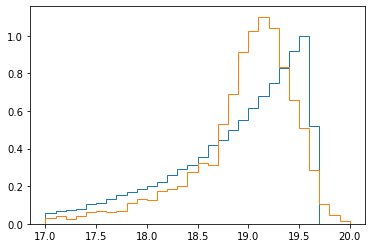

In [29]:
plt.hist(NDE_theta.X[:, 2:3].ravel().cpu().numpy(), 
         histtype='step', density=True, bins=30, range=(17, 20))
plt.hist(mags[:, 2:3].ravel().detach().cpu().numpy(), 
         histtype='step', density=True, bins=30, range=(17, 20))

(array([4.82890101e+00, 5.02759644e-01, 2.61916724e-01, 1.30958339e-01,
        8.27897839e-02, 5.56949256e-02, 4.06422576e-02, 1.65579449e-02,
        1.35474192e-02, 1.50526880e-02, 3.01053544e-03, 9.03161279e-03,
        7.52633861e-03, 6.02107950e-03, 7.52633861e-03, 3.01053544e-03,
        4.51580963e-03, 1.50526772e-03, 1.50526772e-03, 1.50526988e-03,
        1.50526772e-03, 0.00000000e+00, 1.50526988e-03, 1.50526772e-03,
        0.00000000e+00, 1.50526557e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 array([0.        , 0.16666667, 0.33333334, 0.5       , 0.6666667 ,
        0.8333333 , 1.        , 1.1666666 , 1.3333334 , 1.5       ,
        1.6666666 , 1.8333334 , 2.        , 2.1666667 , 2.3333333 ,
        2.5       , 2.6666667 , 2.8333333 , 3.        , 3.1666667 ,
        3.3333333 , 3.5       , 3.6666667 , 3.8333333 , 4.        ,
        4.1666665 , 4.3333335 , 4.5       , 4.6666665 , 4.8333335 ,
        5.        ], dtype=float32),
 [<matplo

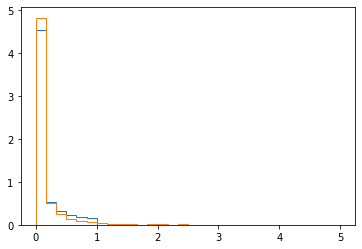

In [20]:
plt.hist(10**(3 * (NDE_theta.X[:, 2:3].ravel().cpu().numpy() - 19.65)), 
         histtype='step', density=True, bins=30, range=(0, 5))
plt.hist(10**(3 * (mags[:, 2:3].ravel().detach().cpu().numpy() - 19.65)), 
         histtype='step', density=True, bins=30, range=(0, 5))

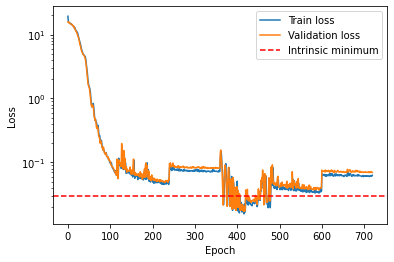

In [35]:
NDE_theta.plot_loss(min_loss=0.03)
plt.yscale('log')

In [22]:
print('Best epoch:', NDE_theta.best_loss_epoch)
print('Best train loss:', NDE_theta.train_loss_history[NDE_theta.best_loss_epoch - 1])
print('Best vali loss:', NDE_theta.vali_loss_history[NDE_theta.best_loss_epoch - 1])

# NDE_theta.best_model.goodness_of_fit(Y_truth, p=1)
# NDE_theta.goodness_of_fit(Y_truth, p=1)

Best epoch: 700
Best train loss: 0.034940510988235474
Best vali loss: 0.025083767250180244


In [29]:
from popsed.nde import transform_nmf_params_given_z, inverse_transform_nmf_params_given_z

In [53]:
samples = NDE_theta.sample(4000)

0 4000
>40 0


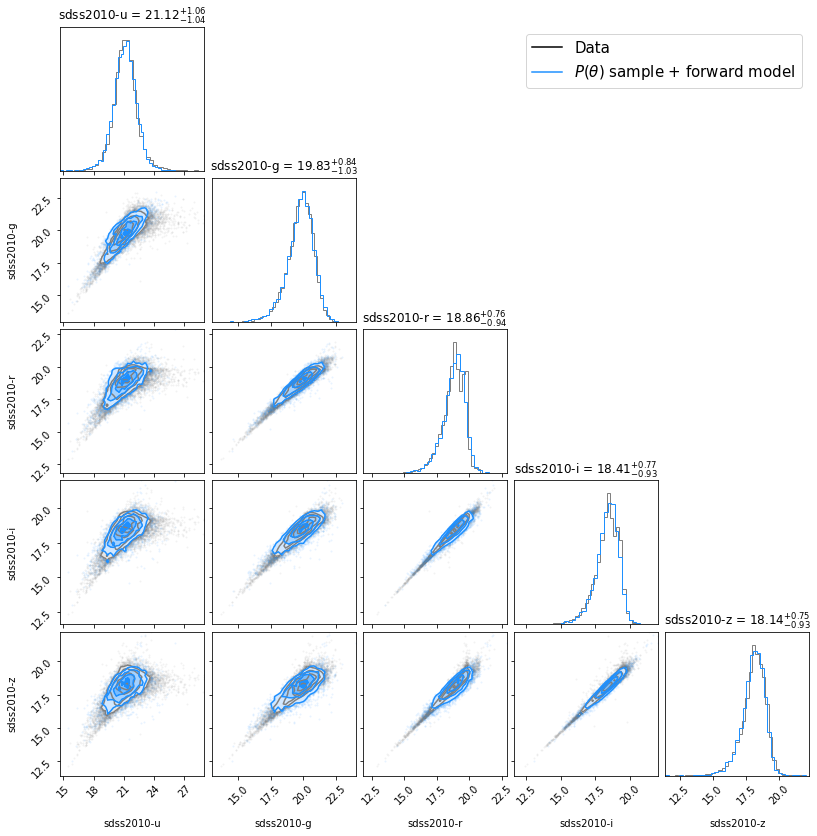

In [54]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = gama_filters

figure = corner.corner(X_vali,#.cpu().detach().numpy(), 
                       color='gray', labels=labels, bins=40,
                       smooth=0.2, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(
#     inverse_transform_nmf_params_given_z(samples, NDE_theta.NDE_prior, NDE_theta.cdf_z), 
    inverse_transform_nmf_params(samples, NDE_theta.NDE_prior),
                                                  filterset=gama_filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>40', np.any(mags > 40, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 40, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=40,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.2, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [32]:
mags[:, 2].max()

24.559788

(array([ 8.26639313,  8.91092601,  9.12523917, 11.05813709, 11.37971003,
        15.0298057 , 15.35255927, 19.10932439, 22.22264128, 23.29724029,
        27.37571752, 31.99344518, 41.00989841, 40.58047539, 44.8767117 ,
        31.99201499, 10.62821974,  1.71776887,  0.53677877,  0.32208166,
         0.        ,  0.        ,  0.10736055,  0.10735575,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 array([1.25     , 1.2526667, 1.2553333, 1.258    , 1.2606666, 1.2633333,
        1.266    , 1.2686666, 1.2713333, 1.274    , 1.2766666, 1.2793334,
        1.282    , 1.2846667, 1.2873334, 1.29     , 1.2926667, 1.2953334,
        1.298    , 1.3006667, 1.3033333, 1.306    , 1.3086667, 1.3113333,
        1.314    , 1.3166667, 1.3193333, 1.322    , 1.3246666, 1.3273333,
        1.33     ], dtype=float32),
 [<matplotlib.patches.Polygon at 0x1535f4195210>])

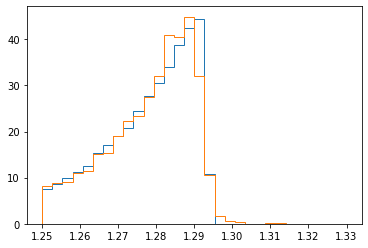

In [33]:
plt.hist(np.log10(X_vali[:, 2]), histtype='step', density=True, bins=30, range=(1.25, 1.33))
plt.hist(np.log10(mags[:, 2]), histtype='step', density=True, bins=30, range=(1.25, 1.33))

(array([2.66032056e+00, 1.07014025e+00, 8.65731515e-01, 6.82364648e-01,
        4.07314726e-01, 1.92384747e-01, 7.96593376e-02, 1.65330582e-02,
        1.20240510e-02, 1.50300637e-03, 4.50901589e-03, 3.00601274e-03,
        0.00000000e+00, 1.50300745e-03, 0.00000000e+00, 1.50300530e-03,
        1.50300745e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 array([0.        , 0.16666667, 0.33333334, 0.5       , 0.6666667 ,
        0.8333333 , 1.        , 1.1666666 , 1.3333334 , 1.5       ,
        1.6666666 , 1.8333334 , 2.        , 2.1666667 , 2.3333333 ,
        2.5       , 2.6666667 , 2.8333333 , 3.        , 3.1666667 ,
        3.3333333 , 3.5       , 3.6666667 , 3.8333333 , 4.        ,
        4.1666665 , 4.3333335 , 4.5       , 4.6666665 , 4.8333335 ,
        5.        ], dtype=float32),
 [<matplo

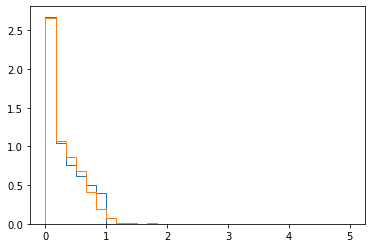

In [34]:
plt.hist(10**(X_vali[:, 2] - 19.65), histtype='step', density=True, bins=30, range=(0, 5))
plt.hist(10**(mags[:, 2] - 19.65), histtype='step', density=True, bins=30, range=(0, 5))

In [55]:
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()
_samples = np.hstack([prior.FlatDirichletPrior(4).transform(_samples_unt[:, :3]),
                      _samples_unt[:, 3:-1], 
                      _samples_unt[:, -1:]])

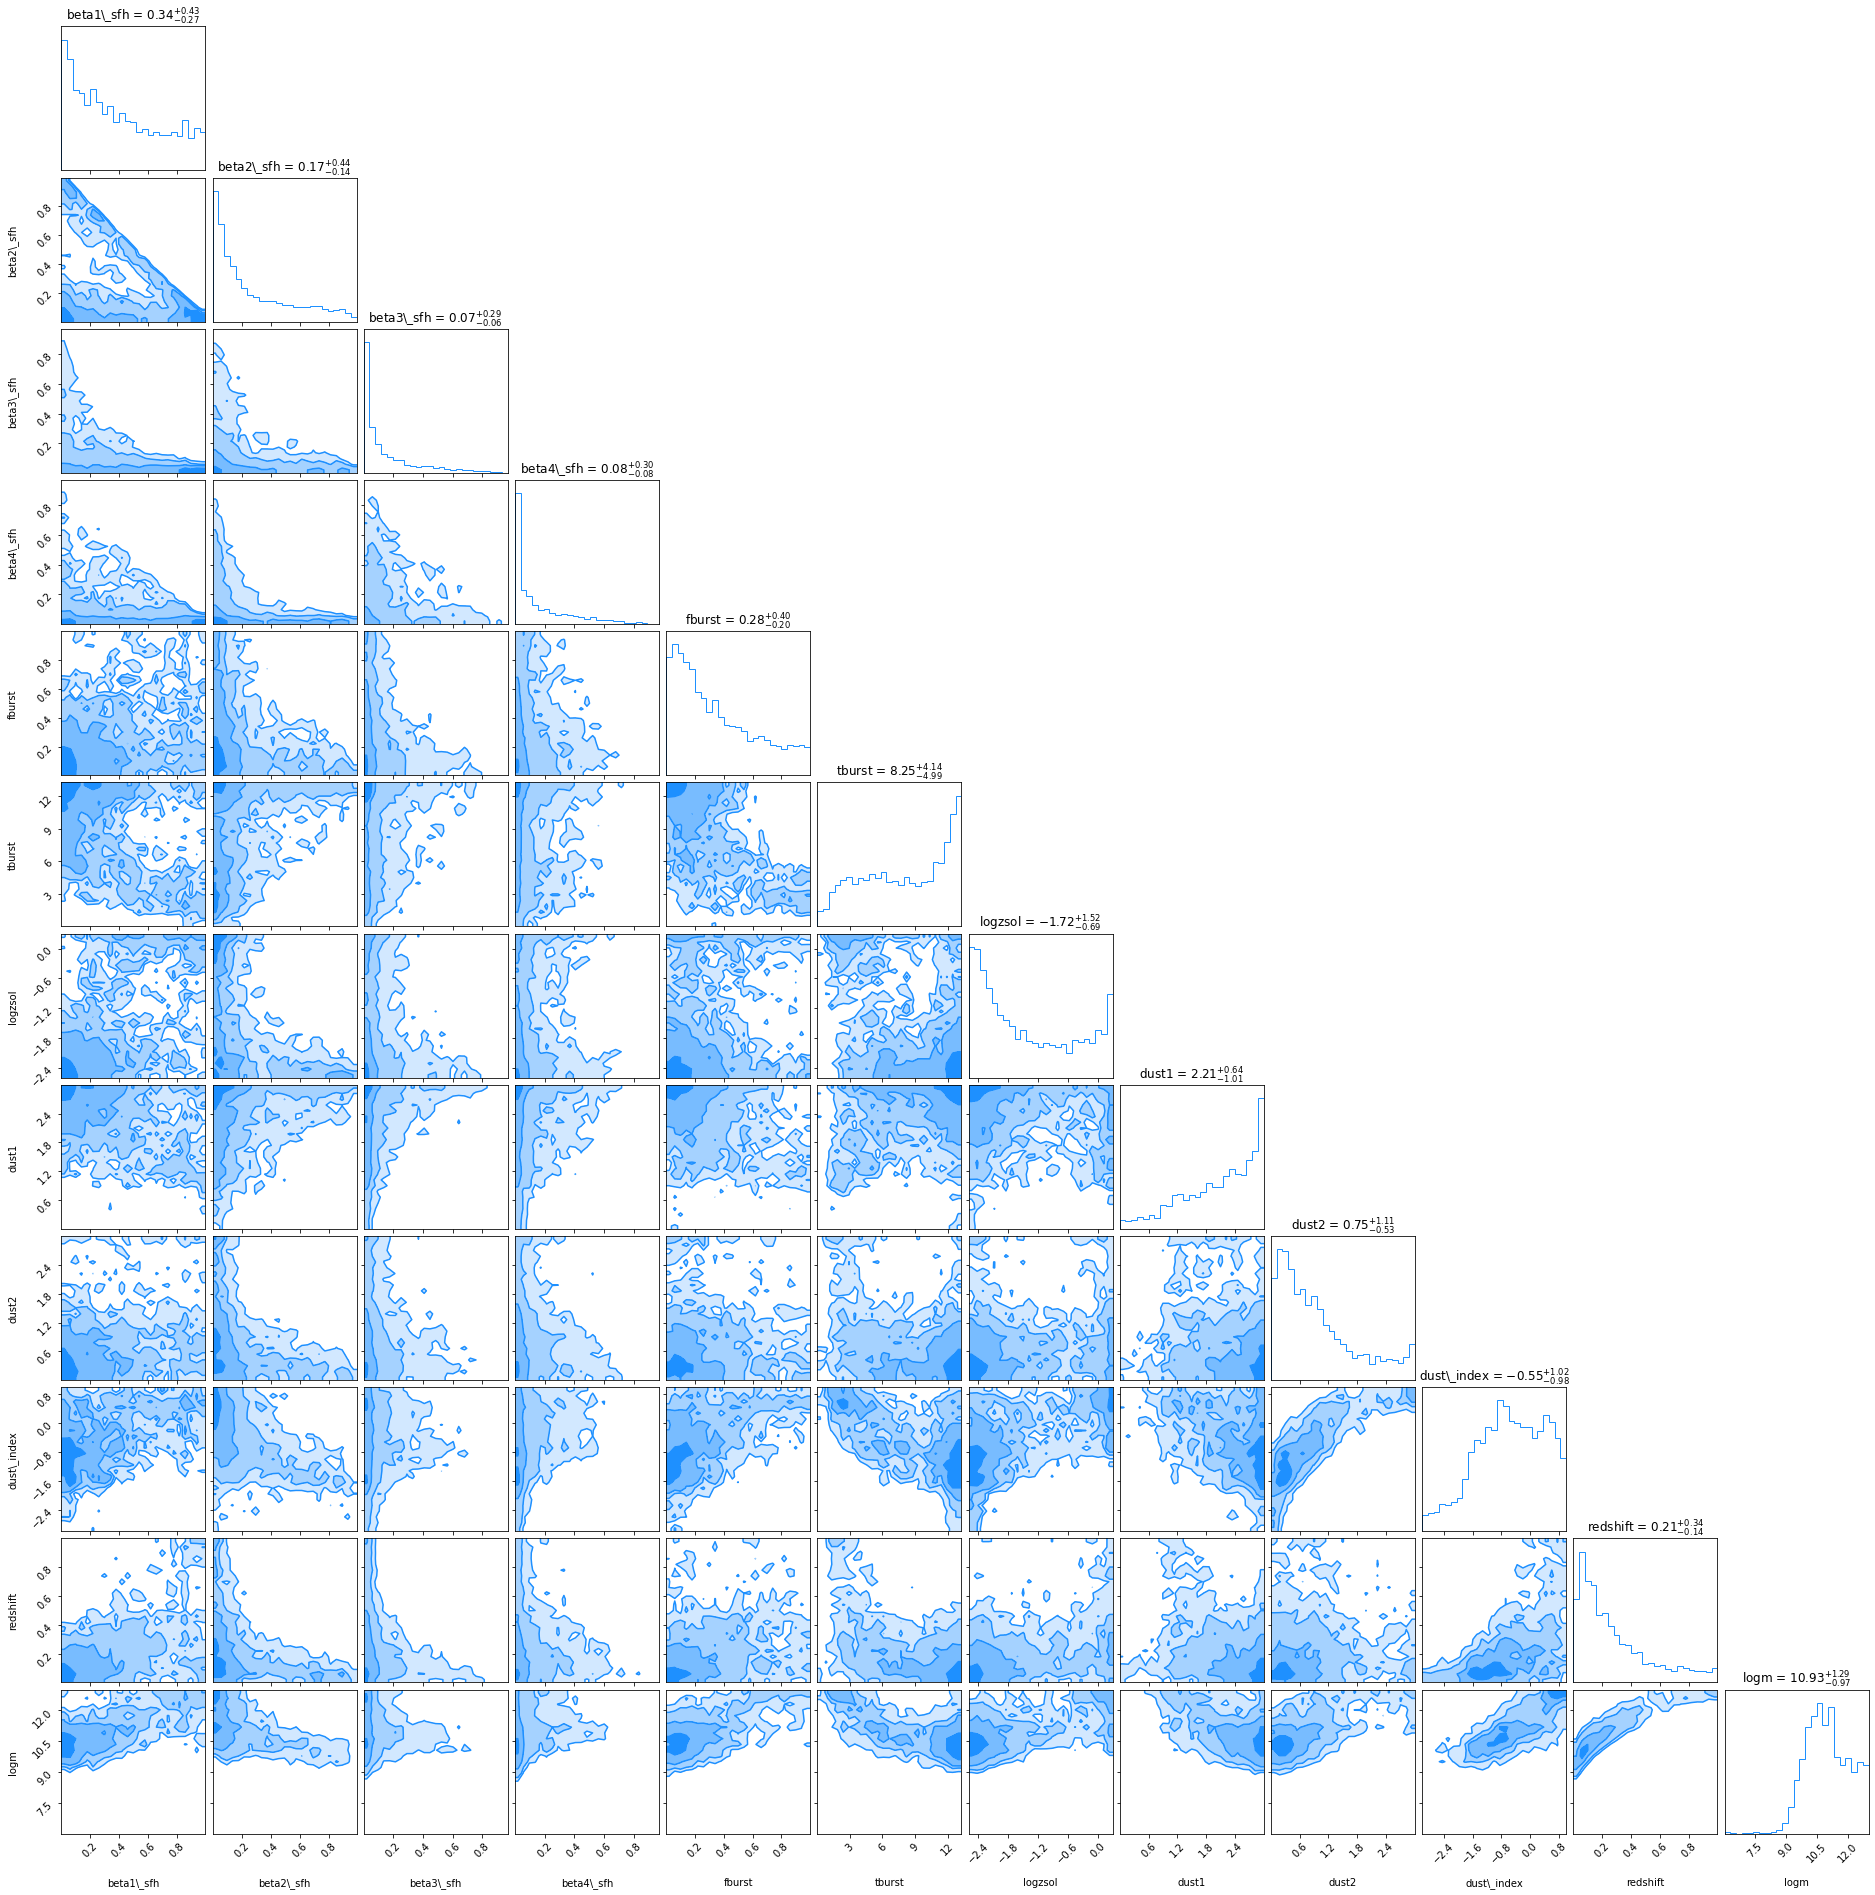

In [56]:
_labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]

nf_plot = corner.corner(_samples, 
                  labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [57]:
z_mass_truth = np.load('./reference_catalog/GAMA/gama_clean_z_mass_dr3_apmatch.npy')

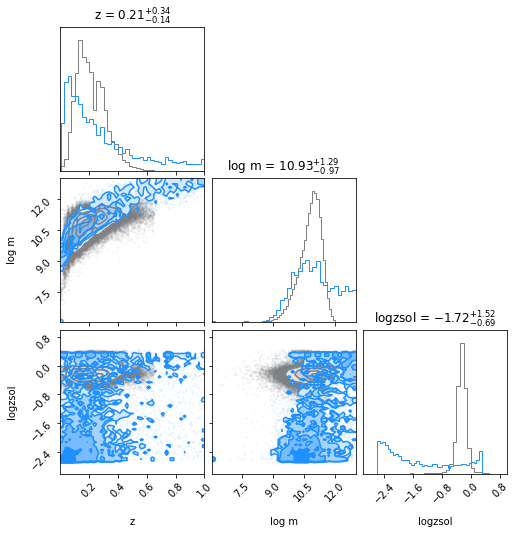

In [58]:
figure = corner.corner(z_mass_truth, 
                  labels=['z', 'log m', 'logzsol'], bins=40,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                       range=[[0, 1], [8, 12], [-3, 1]], 
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples[:, -2:], _samples[:, 6:7]]), 
                       fig=figure,
                  labels=['z', 'log m', 'logzsol'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [35]:
a, b = np.histogram(z_mass_truth[:, 0].ravel(), bins=35, range=(0, 0.5))
b[np.argmax(a)]

0.15714286

In [36]:
a, b = np.histogram(y_truth_trans[:, -2].ravel(), bins=35, range=(0, 0.5))
b[np.argmax(a)]

0.21428571428571427

In [37]:
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()

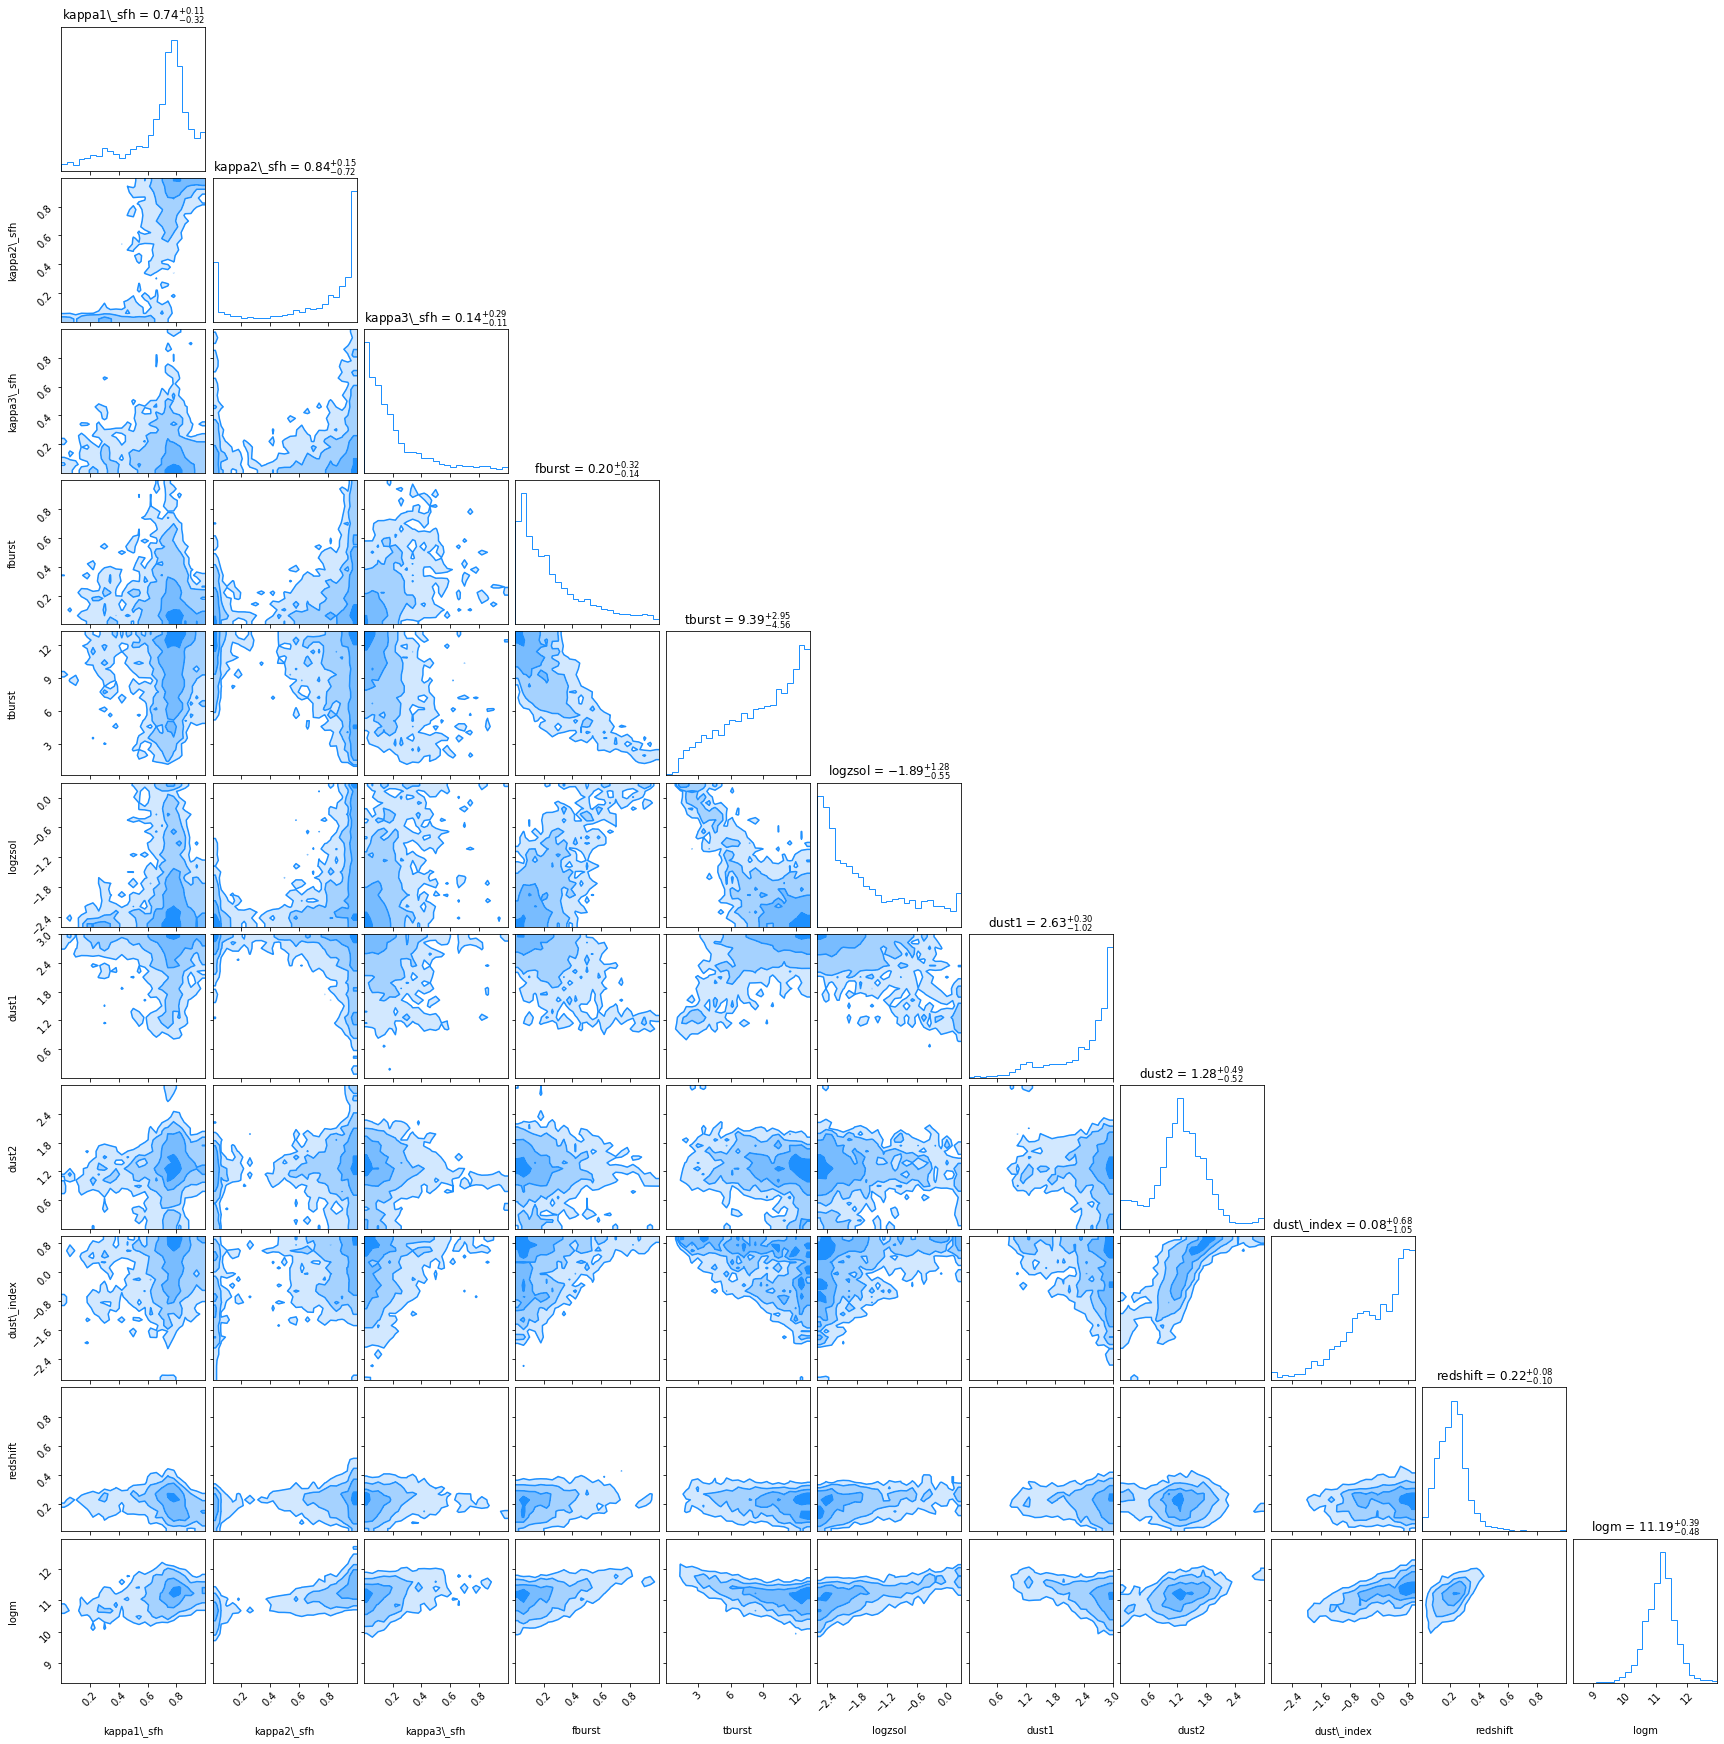

In [38]:
_labels = [f'kappa{i}_sfh' for i in range(1,4)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]

nf_plot = corner.corner(_samples_unt, 
                  labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [62]:
fake_z_mass = z_mass_truth[np.random.choice(np.arange(len(z_mass_truth)), size=(4000,), replace=False)]
fake_sample = torch.hstack([inverse_transform_nmf_params(samples, NDE_theta.NDE_prior)[:, :-2], 
              torch.Tensor(fake_z_mass).to('cuda')])
fake_sample[:, 6] *= 0.0
fake_sample[:, 7] *= 0.0
fake_sample[:, 8] *= 0.0

fake_mags = speculator._predict_mag_with_mass_redshift(
    fake_sample,
                                                  filterset=gama_filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()

In [63]:
fake_sample[0]

tensor([ 0.8676,  0.9785,  0.9872,  0.0245,  9.4483, -0.4076,  0.0000,  0.0000,
         0.0000,  0.2178, 11.3518], device='cuda:0', grad_fn=<SelectBackward0>)

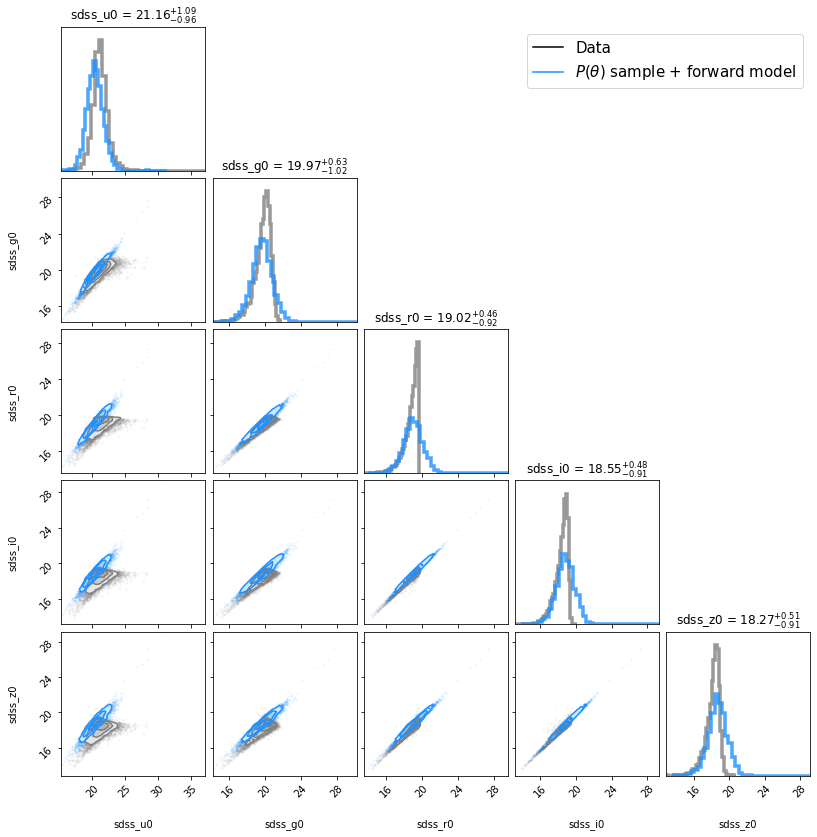

In [64]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = gama_filters

figure = corner.corner(X_vali,#.cpu().detach().numpy(), 
                       color='gray', labels=labels, bins=40,
                       smooth=0.2, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})


nf_plot = corner.corner(fake_mags, 
                  fig=figure, labels=labels, bins=40,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.2, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [142]:
NDE_theta.penalty_powers = [10] * 11

In [144]:
n_samples = len(NDE_theta.X.detach())

L = SamplesLoss(loss="sinkhorn", **{'p': 1, 'blur': 0.1, 'scaling': 0.8})


NDE_theta.optimizer.param_groups[0]['lr'] = 1e-6
NDE_theta.optimizer.zero_grad()
loss, bad_ratio = NDE_theta._get_loss_NMF(NDE_theta.X.detach(), speculator, n_samples,
                                 noise, None, noise_model_dir, L)
print(loss, bad_ratio)
loss.backward()
# NDE_theta.optimizer.step()
#     NDE_theta.sample(1)

Bad mask num tensor(3296, device='cuda:0')
Number of inf: tensor(0, device='cuda:0')
tensor(14.0700, device='cuda:0', grad_fn=<AddBackward0>) tensor(13.3888, device='cuda:0', grad_fn=<MeanBackward0>)


kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar

In [6]:
params = np.load('./nsa_sedflow/params_posterior.npy')
params = params[np.random.randint(0, len(params), 15000)]

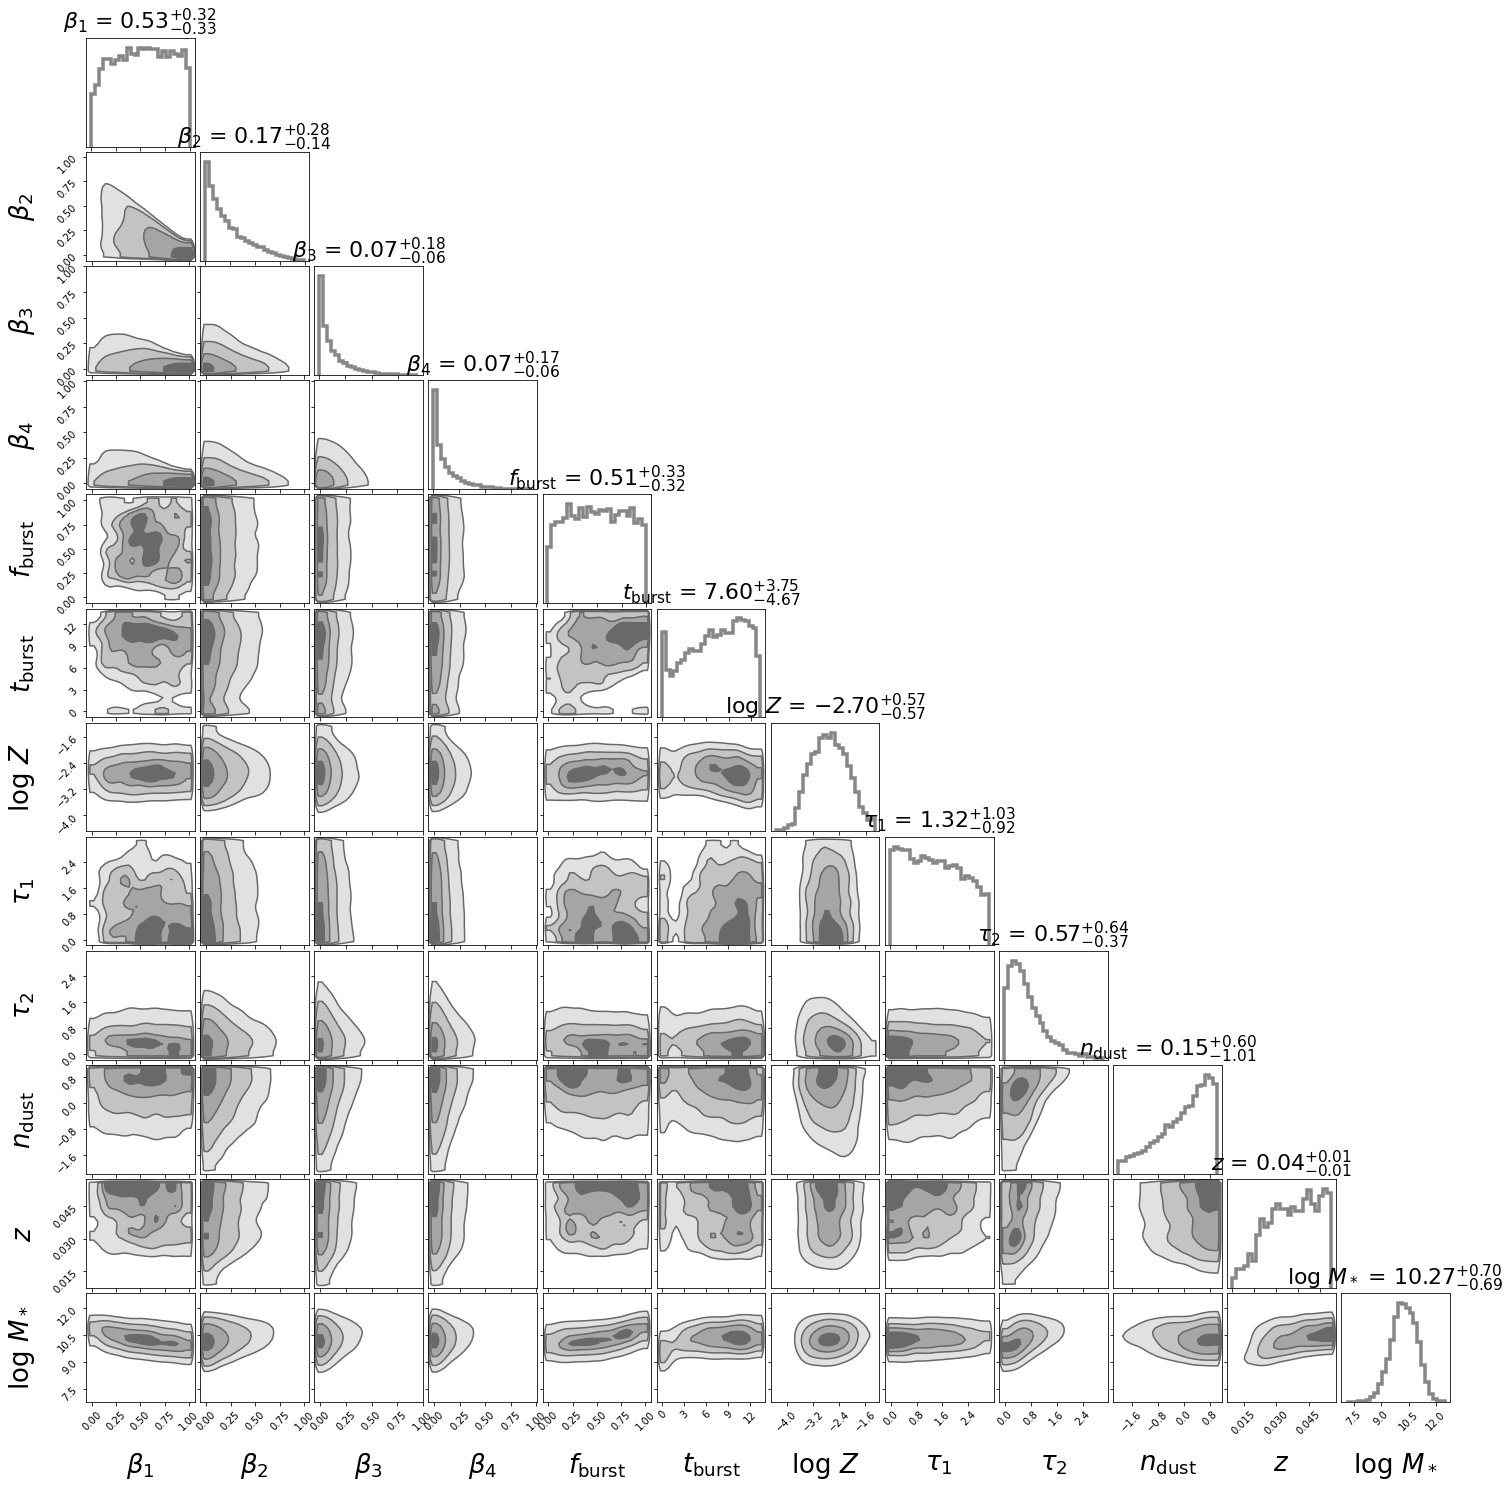

In [40]:
import matplotlib.lines as mlines

labels = [
    r'$\beta_{1}$',
    r'$\beta_{2}$',
    r'$\beta_{3}$',
    r'$\beta_{4}$',
    r'$f_{\mathrm{burst}}$',
    r'$t_{\mathrm{burst}}$',
    r'$\log\,Z$',
    r'$\tau_1$',
    r'$\tau_2$',
    r'$n_{\mathrm{dust}}$',
    r'$z$',
    r'$\log\,M_*$',
    ]

figure, axes = plt.subplots(12, 12, figsize=(20, 20))
figure = corner.corner(
    params,
    fig=figure,
    color='dimgray',
    labels=labels,
    bins=25,
    smooth=1.5,
    fill_contours=True,
    show_titles=True,
#     title_fmt=None,
    title_kwargs={'fontsize': 22},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True},
    plot_datapoints=False
    )

In [7]:
params = np.hstack([prior.FlatDirichletPrior(4).untransform(params[:, 0:4]), params[:, 4:]])

In [8]:
params.shape

(15000, 11)

In [9]:
torch.cuda.empty_cache()

In [19]:
_mag = speculator._predict_mag_with_mass_redshift(
                    params,
                    noise=noise, SNR=None, noise_model_dir=noise_model_dir)

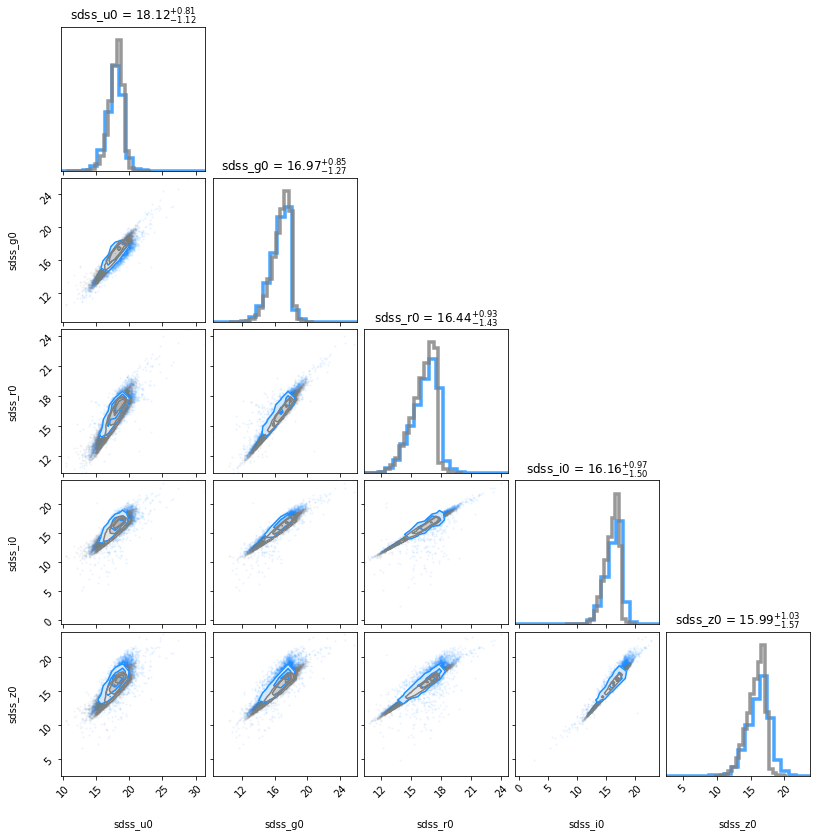

In [20]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Noise-less photometry')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'Noisy photometry')

labels = filters # [f'sdss\_{f}0' for f in 'ugriz']

figure = corner.corner(_mag.cpu().detach().numpy()[:, :], 
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

figure = corner.corner(mags_nsa,
                       fig=figure,
                       color='gray', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

# ax = nf_plot.get_axes()[4]
# ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [23]:
L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 1e-3, 'scaling': 0.9})
print("Intrinsic sampling loss:", L(torch.Tensor(mags_nsa[:5000]).to('cuda'), _mag[:5000]).item())

Intrinsic sampling loss: 0.8318371176719666
